<a href="https://colab.research.google.com/github/Vedanti0404/Data_science_internship/blob/main/Customer_Lifetime_Value_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
retail_df = pd.read_excel('https://github.com/fenago/datasets/raw/main/Online%20Retail.xlsx')


In [ ]:
retail_df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
retail_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
retail_df.shape


(541909, 8)

In [ ]:
retail_df.isnull().sum()


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
retail_df.drop_duplicates(inplace = True)


In [ ]:
retail_df.dropna(subset = ['CustomerID'], inplace = True)


In [ ]:
retail_df['Total'] = retail_df['Quantity'] * retail_df['UnitPrice']


In [ ]:
retail_df["InvoiceDate"].max()


Timestamp('2011-12-09 12:50:00')

In [ ]:
import datetime as dt

#Recency
latest_date = retail_df['InvoiceDate'].max() + dt.timedelta(days = 1)

rfm = retail_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,
    'InvoiceNo': 'count',
    'Total': 'sum'
}).reset_index()

rfm.rename(columns = {
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'Total': 'MonetaryValue'
}, inplace = True)

In [ ]:
#Recency score based on quantiles
#Assigning labels from 1-5,  1 being the lowest recency
rfm["Recency_score"] = pd.qcut(rfm['Recency'], 5, labels = [5, 4, 3, 2, 1])

#Frequency score
rfm["Frequency_score"] = pd.qcut(rfm['Frequency'].rank(method = "first"), 5, labels = [1, 2, 3, 4, 5])

In [ ]:
#Combine Recency and Frequency scores to create RFM Segment
rfm["rfm_segment"] = rfm['Recency_score'].astype(str) + rfm['Frequency_score'].astype(str)

In [ ]:
rfm


,CustomerID,Recency,Frequency,MonetaryValue,Recency_score,Frequency_score,rfm_segment
0,12346.0,326,2,0.00,1,1,11
1,12347.0,2,182,4310.00,5,5,55
2,12348.0,75,31,1797.24,2,3,23
3,12349.0,19,73,1757.55,4,4,44
4,12350.0,310,17,334.40,1,2,12
...,...,...,...,...,...,...,...
4367,18280.0,278,10,180.60,1,1,11
4368,18281.0,181,7,80.82,1,1,11
4369,18282.0,8,13,176.60,5,1,51
4370,18283.0,4,721,2045.53,5,5,55


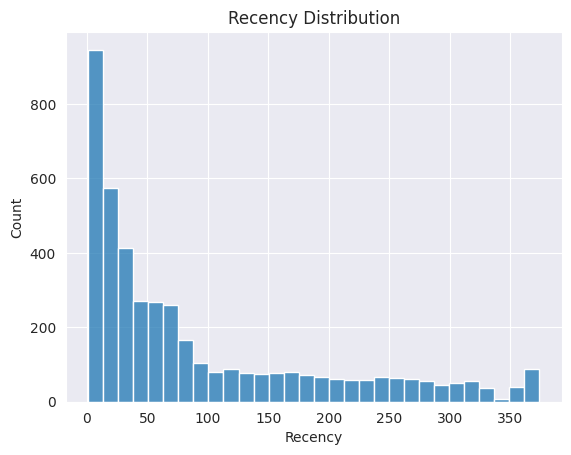

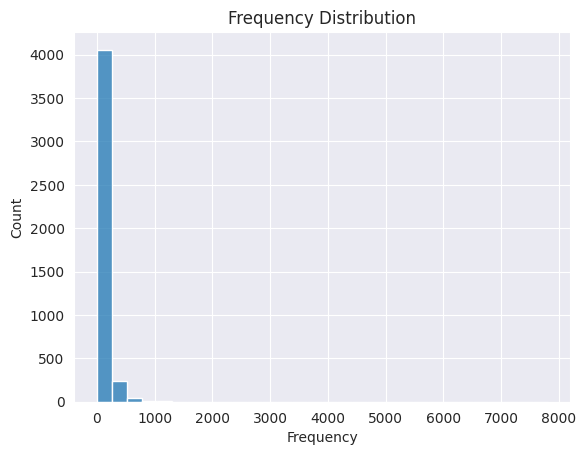

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
#Eliminating Future warning
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
####################################
# recency Distribution
sns.histplot(data = rfm, x = 'Recency', bins = 30)
plt.title('Recency Distribution')
plt.show()# Frequency Distribution
sns.histplot(data = rfm, x = 'Frequency', bins = 30)
plt.title('Frequency Distribution')
plt.show()

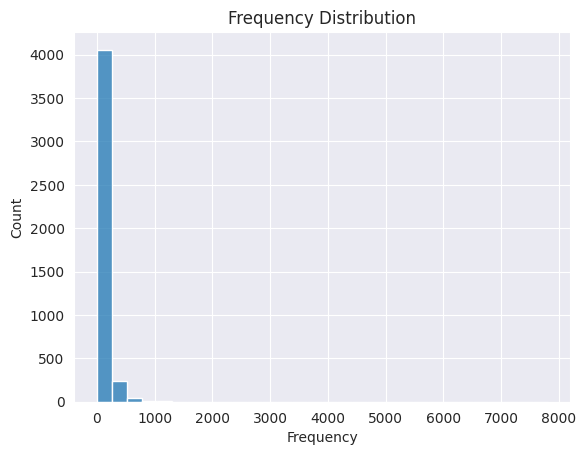

In [ ]:
# Frequency Distribution
sns.histplot(data = rfm, x = 'Frequency', bins = 30)
plt.title('Frequency Distribution')
plt.show()

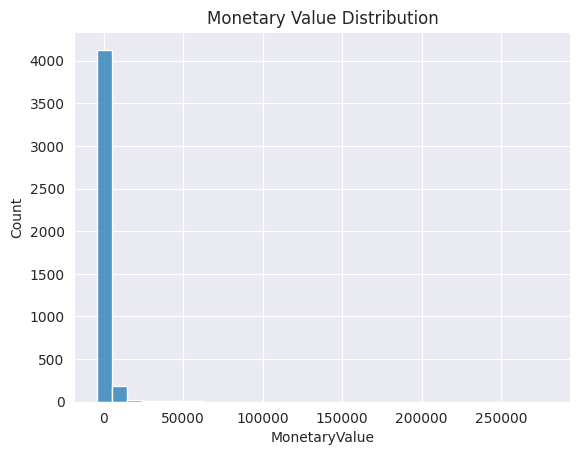

In [ ]:
# Monetary Distribution
sns.histplot(data = rfm, x = 'MonetaryValue', bins = 30)
plt.title('Monetary Value Distribution')
plt.show()

In [ ]:
#Mapping segments to their corresponding customer segments
segment_map = {
    r'[1-2][1-2]' : 'Hibernating',
    r'[1-2][3-4]' : 'At-Risk',
    r'[1-2]5' : "Can\'t Loose",
    r'3[1-2]' : 'About to Slip',
    r'33' : 'Need Attention',
    r'[3-4][4-5]' : 'Loyal Customers',
    r'41' : 'Promising',
    r'51' : 'New Customers',
    r'[4-5][2-3]' : 'Potential Loyalists',
    r'5[4-5]' : 'Champions',
}

In [ ]:
#Mapping RFM segments to corresponding customer segments
rfm['rfm_segment'] = rfm['rfm_segment'].replace(segment_map, regex = True)

In [ ]:
rfm


,CustomerID,Recency,Frequency,MonetaryValue,Recency_score,Frequency_score,rfm_segment
0,12346.0,326,2,0.00,1,1,Hibernating
1,12347.0,2,182,4310.00,5,5,Champions
2,12348.0,75,31,1797.24,2,3,At-Risk
3,12349.0,19,73,1757.55,4,4,Loyal Customers
4,12350.0,310,17,334.40,1,2,Hibernating
...,...,...,...,...,...,...,...
4367,18280.0,278,10,180.60,1,1,Hibernating
4368,18281.0,181,7,80.82,1,1,Hibernating
4369,18282.0,8,13,176.60,5,1,New Customers
4370,18283.0,4,721,2045.53,5,5,Champions


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'MonetaryValue']])

rfm_scaled


array([[ 2.32202285, -0.39205597, -0.23041952],
       [-0.89373323,  0.39329343,  0.29405454],
       [-0.1691956 , -0.26552745, -0.01171748],
       ...,
       [-0.83418219, -0.34406239, -0.20892947],
       [-0.87388289,  2.74497857,  0.01849636],
       [-0.48680114, -0.09536842, -0.00684511]])

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 4, random_state = 42)
kmeans.fit(rfm_scaled)
rfm['Cluster'] = kmeans.labels_

In [ ]:
rfm


,CustomerID,Recency,Frequency,MonetaryValue,Recency_score,Frequency_score,rfm_segment,Cluster
0,12346.0,326,2,0.00,1,1,Hibernating,3
1,12347.0,2,182,4310.00,5,5,Champions,0
2,12348.0,75,31,1797.24,2,3,At-Risk,0
3,12349.0,19,73,1757.55,4,4,Loyal Customers,0
4,12350.0,310,17,334.40,1,2,Hibernating,3
...,...,...,...,...,...,...,...,...
4367,18280.0,278,10,180.60,1,1,Hibernating,3
4368,18281.0,181,7,80.82,1,1,Hibernating,3
4369,18282.0,8,13,176.60,5,1,New Customers,0
4370,18283.0,4,721,2045.53,5,5,Champions,0


In [ ]:
new_rfm = rfm[["Recency", "Frequency", "MonetaryValue", "rfm_segment"]]

In [ ]:
#Convert index to integer
new_rfm.index = new_rfm.index.astype(int)
new_rfm.head()

,Recency,Frequency,MonetaryValue,rfm_segment
0,326,2,0.00,Hibernating
1,2,182,4310.00,Champions
2,75,31,1797.24,At-Risk
3,19,73,1757.55,Loyal Customers
4,310,17,334.40,Hibernating


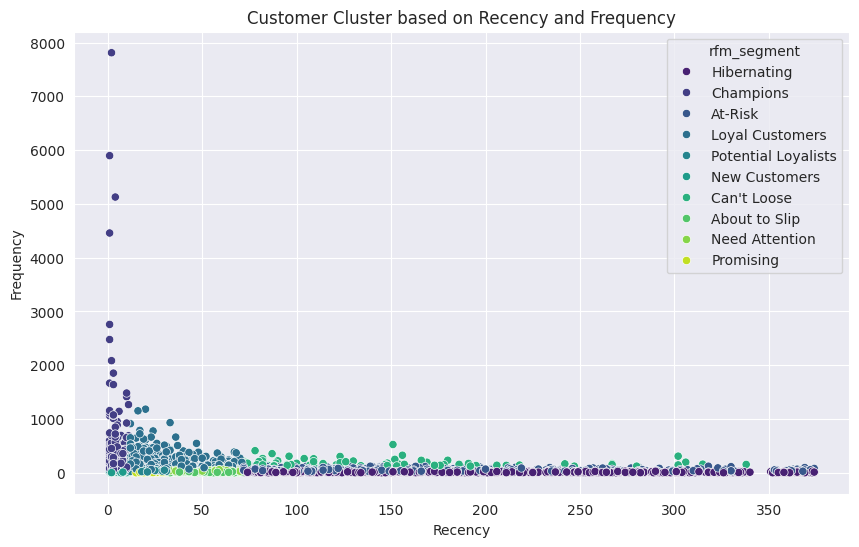

In [ ]:
plt.figure(figsize = (10, 6))
sns.scatterplot(x = 'Recency', y = 'Frequency', hue = 'rfm_segment', data = new_rfm, palette = 'viridis')
plt.title('Customer Cluster based on Recency and Frequency')
plt.show()

In [ ]:
import plotly.express as px
#Top 10 most preferred products
segments = new_rfm['rfm_segment'].value_counts()

fig = px.bar(
     x = segments.index,
     y = segments.values,
     color = segments.index,
     text = segments.values,
     title = "RFM Segments"
)
fig.update_layout(
    xaxis_title="Segment",
    yaxis_title="Count",
    font=dict(size=15, family="Arial"),
    title_font=dict(size=20, family="Arial")
)
fig.show()

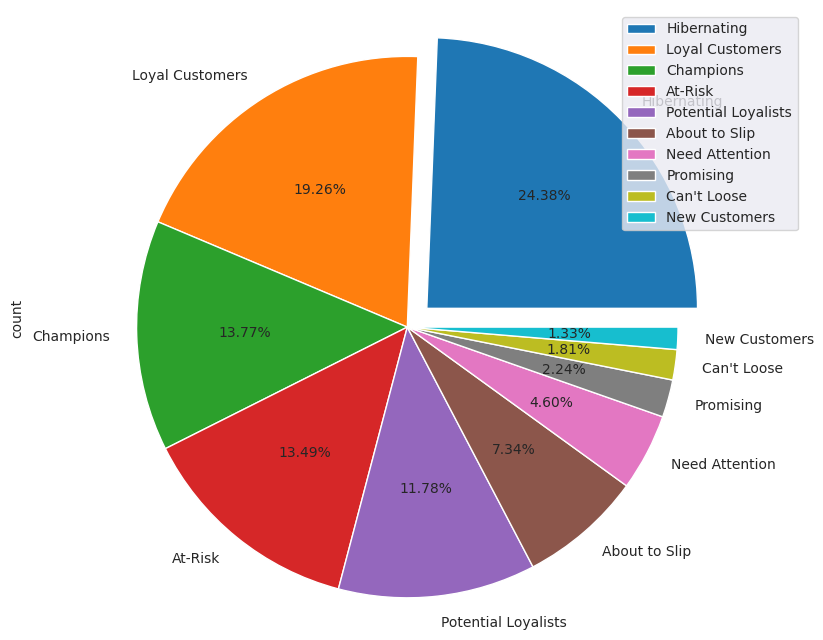

In [ ]:
plt.figure(figsize = (10, 8), )
explode = (0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0)

segments.plot(
    kind = 'pie',
    explode = explode,
    autopct = '%1.2f%%')
plt.axis('equal')
plt.legend(labels = segments.index, loc = "best")
plt.show()

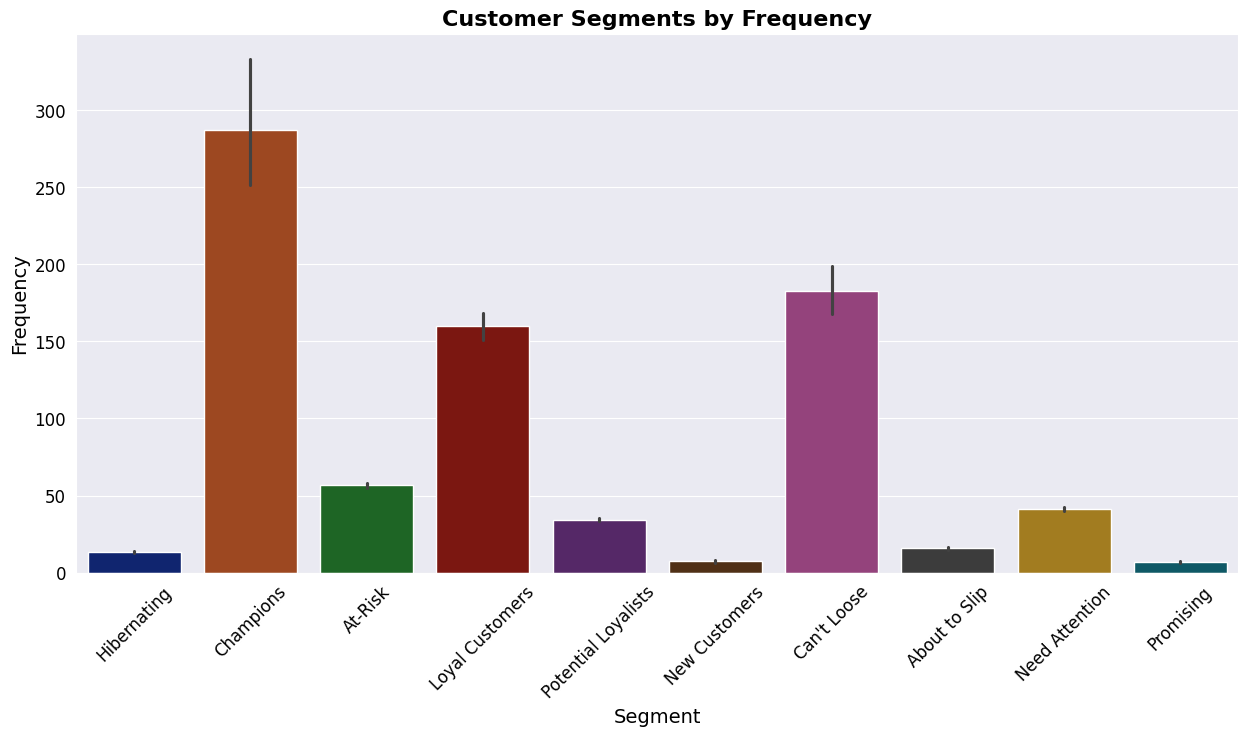

In [ ]:
sns.set_style("darkgrid")
colors = sns.color_palette("dark")

# Create the plot
plt.figure(figsize=(15, 7))
sns.barplot(x = "rfm_segment", y = "Frequency", data = new_rfm, palette=colors)
plt.title("Customer Segments by Frequency", color='black', fontsize=16, fontweight='bold')
plt.xlabel("Segment", color='black', fontsize=14)
plt.ylabel("Frequency", color='black', fontsize=14)
plt.xticks(rotation=45, color='black', fontsize=12)
plt.yticks(color='black', fontsize=12)
plt.show()

In [ ]:
new_rfm[["rfm_segment","Recency", "Frequency", "MonetaryValue"]].groupby("rfm_segment").agg(["mean", "count","sum"])

Recency                 Frequency                \
                           mean count     sum        mean count     sum   
rfm_segment                                                               
About to Slip         52.239875   321   16769   15.732087   321    5050   
At-Risk              164.706780   590   97177   56.532203   590   33354   
Can't Loose          140.620253    79   11109  182.607595    79   14426   
Champions              5.280731   602    3179  287.362126   602  172992   
Hibernating          212.132270  1066  226133   13.332083  1066   14212   
Loyal Customers       32.276722   842   27177  159.731591   842  134494   
Need Attention        51.213930   201   10294   41.079602   201    8257   
New Customers          6.689655    58     388    7.517241    58     436   
Potential Loyalists   15.491262   515    7978   34.339806   515   17685   
Promising             22.714286    98    2226    7.122449    98     698   

                    MonetaryValue                     
                             mean count          sum  
rfm_segment                                           
About to Slip          410.643209   321   131816.470  
At-Risk                949.998797   590   560499.290  
Can't Loose           2359.026595    79   186363.101  
Champions             6903.407957   602  4155851.590  
Hibernating            368.246953  1066   392551.252  
Loyal Customers       2575.195285   842  2168314.430  
Need Attention         799.003985   201   160599.801  
New Customers          675.133103    58    39157.720  
Potential Loyalists    858.925670   515   442346.720  
Promising              418.561735    98    41019.050

In [ ]:
features = rfm[['Recency', 'Frequency', 'MonetaryValue']]


In [ ]:
# Target Variable
import numpy as np
#MoneytaryValue = rfm['MonetaryValue']
rfm['FutureSpending'] = np.random.rand(len(rfm)) * 3000

In [ ]:
rfm


,CustomerID,Recency,Frequency,MonetaryValue,Recency_score,Frequency_score,rfm_segment,Cluster,FutureSpending
0,12346.0,326,2,0.00,1,1,Hibernating,3,2388.856541
1,12347.0,2,182,4310.00,5,5,Champions,0,1372.163358
2,12348.0,75,31,1797.24,2,3,At-Risk,0,2105.647549
3,12349.0,19,73,1757.55,4,4,Loyal Customers,0,2695.173244
4,12350.0,310,17,334.40,1,2,Hibernating,3,1503.598258
...,...,...,...,...,...,...,...,...,...
4367,18280.0,278,10,180.60,1,1,Hibernating,3,1007.108888
4368,18281.0,181,7,80.82,1,1,Hibernating,3,1990.341330
4369,18282.0,8,13,176.60,5,1,New Customers,0,1584.722344
4370,18283.0,4,721,2045.53,5,5,Champions,0,1253.410574


In [ ]:
from sklearn.model_selection import train_test_split

X = features
y = rfm['FutureSpending']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

pred = lin_reg.predict(X_test)

mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 742438.1642684441
R^2 Score: 0.0011143566976370423


In [ ]:
results_df = pd.DataFrame({'Future Spending': y_test, 'Predicted Spending': pred})
results_df

,Future Spending,Predicted Spending
2014,1321.911126,1462.893469
457,895.744443,1488.447326
478,2094.020572,1447.565260
438,1136.215823,1495.560482
3728,2743.944783,1499.428951
...,...,...
733,2725.210127,1497.458398
56,2776.000515,1491.368013
2323,1917.161596,1496.858049
1720,310.812491,1465.043499


In [ ]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)

DecisionTreeRegressor()

In [ ]:
dtr_pred = dtr.predict(X_test)
mse = mean_squared_error(y_test, dtr_pred)
r2 = r2_score(y_test, dtr_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 1519465.2159991036
R^2 Score: -1.0443076107952423


In [ ]:
results_df = pd.DataFrame({'Future Spending': y_test, 'Predicted Spending': dtr_pred})
results_df

,Future Spending,Predicted Spending
2014,1321.911126,2850.337279
457,895.744443,1648.508067
478,2094.020572,2434.736814
438,1136.215823,2443.086641
3728,2743.944783,2042.600172
...,...,...
733,2725.210127,2461.102522
56,2776.000515,2496.040682
2323,1917.161596,558.108426
1720,310.812491,1596.379675


In [ ]:
new_customer_rfm = np.array([[10, 5, 300]])
pred_spending = lin_reg.predict(new_customer_rfm)

print(f"Predicted Future Spending: {pred_spending[0]}")

Predicted Future Spending: 1502.496488714297


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

